# BAD CODE:

In [453]:
import numpy as np
from scipy.integrate import solve_ivp

RNG = np.random.default_rng()

def A_matrix_calculator(matrix_parameters):
    N, s, sigma, gamma = matrix_parameters

    mu = s / N
    var = sigma**2 / N
    cov = gamma * var
    covmat = np.array([[var, cov], [cov, var]])

    S = np.empty((N, N), dtype=float)
    S.fill(np.nan)  
    di = np.diag_indices(N)
    S[di] = 0.0

    iu, ju = np.triu_indices(N, k=1)
    m = iu.size
    if m > 0:
        draws = RNG.multivariate_normal(mean=[mu, mu], cov=covmat, size=m)
        S[iu, ju] = draws[:, 0]
        S[ju, iu] = draws[:, 1]

    return S

def dndt(t, n_arr, r, k, migration, A_matrix):
    n_arr = np.maximum(n_arr, 0.0)

    interaction_terms = A_matrix.dot(n_arr)
    return (r / k) * n_arr * (k - n_arr) - n_arr * interaction_terms + migration

def solver(N, t_array, sigma, n_i_0, A_matrix, r, k, migration):
    
    args = (r, k, migration, A_matrix)
    fun = lambda t, y: dndt(t, y, *args)
    sol = solve_ivp(fun, t_span=(t_array[0], t_array[-1]), y0=np.asarray(n_i_0, dtype=float), method = 'BDF', t_eval=t_array, rtol=1e-9, atol=1e-12,
                    events = stable_event, max_step=1.0, vectorized=False)
    return sol

stability_tol = 1e-10 

def stable_event(t, n_arr, r, k, migration, A_matrix):

    n_dot = dndt(n_arr, r, k, migration, A_matrix)

    epsilon = 1e-300
    n_safe = np.maximum(n_dot, epsilon)

    dln_dt = n_dot / n_safe

    max_abs = np.max(np.abs(dln_dt))

    return max_abs - stability_tol

stable_event.terminal = True
stable_event.direction = -1

def GLV_solver(N, sigma, birth_rate, carrying_capacity, initial_species_value, A_full=None, max_time = 500):
    dt = 0.1
    block_time = 20.0
    r = birth_rate
    k = carrying_capacity
    s = 1.0
    gamma = 1
    migration = 1e-8

    if A_full is None:
        matrix_parameters = (N, s, sigma, gamma)
        A_full = A_matrix_calculator(matrix_parameters)

    n0 = np.asarray(initial_species_value, dtype=float)

    t0 = 0.0
    t1 = block_time

    t_parts = []   
    y_parts = []

    max_population = 100.0

    # safety: ensure n0 has shape (N,)
    if n0.ndim == 2 and n0.shape[0] != N:
        n0 = n0.ravel()

    while t1 <= max_time:
        time_array = np.arange(t0, t1, dt)
        if time_array.size == 0:
            break

        sol = solver(N, time_array, sigma, n0, A_full, r, k, migration)
        if np.any(sol.y > max_population):
            break
        t_parts.append(sol.t)
        y_parts.append(sol.y.copy())

        # get last and previous columns safely
        n_last = sol.y[:, -1].copy()

        if sol.y.shape[1] > 1:
            n_prev = sol.y[:, -2]

            max_abs_diff = np.max(np.abs(n_last - n_prev))
            if max_abs_diff < 1e-5:
                break

        # prepare for next block
        n0 = n_last
        t0 = t1
        t1 += block_time

    # final concatenation once
    if len(t_parts) == 0:
        all_t = np.array([])
        all_y = np.empty((N, 0))
    else:
        all_t = np.concatenate(t_parts)
        all_y = np.hstack(y_parts)

    final_species_values = all_y.T[-1] if all_y.size else np.zeros(N)
    return final_species_values


def pertubation_calculator(sigma, N):

    initial_species = 0.5*np.ones(N, dtype=float)
    initial_birth_rate = 1.0
    initial_carrying_capacity = 1.0

    # Generate matrix once
    s = 1.0
    gamma = 1
    matrix_parameters = (N, s, sigma, gamma)
    A_full = A_matrix_calculator(matrix_parameters)

    n_f = GLV_solver(N, sigma, initial_birth_rate, initial_carrying_capacity, initial_species, A_full=A_full, max_time=500)

    perturbed_birth_rate = 1.01
    perturbed_carrying_capacity = perturbed_birth_rate * initial_carrying_capacity / initial_birth_rate

    perturbed_n_f = GLV_solver(N, sigma, perturbed_birth_rate, perturbed_carrying_capacity, n_f, A_full=A_full, max_time=500)

    # keep original formula
    order_parameter = (perturbed_n_f - n_f) / (perturbed_birth_rate - initial_birth_rate) + \
                      (perturbed_n_f - n_f) / (perturbed_carrying_capacity - initial_carrying_capacity)
    return order_parameter


# # End of optimized file


/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_13134/3084953092.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


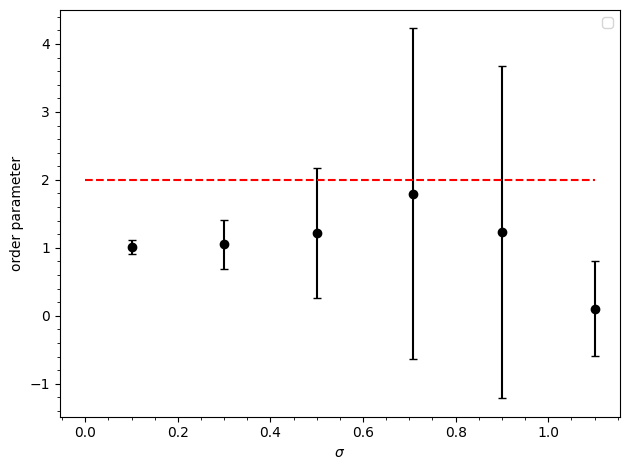

In [235]:
import matplotlib.pyplot as plt

plt.errorbar(std_array, mean_delta_N_array, yerr = std_delta_N_array, fmt = 'ko', capsize = 3)
plt.hlines(2, 0, std_array[-1], color = 'r', linestyles='--')
plt.xlabel(r"$\sigma$")
plt.ylabel(r"order parameter")
plt.legend()
plt.minorticks_on()
plt.tight_layout()
plt.show()

Stability event time(s): [89.50084483]
Stability event time(s): [19.14456501]
Stability event time(s): [90.32934861]
Stability event time(s): [19.14465835]
Stability event time(s): [85.1095065]
Stability event time(s): [19.14476596]
Stability event time(s): [84.61211845]
Stability event time(s): [19.14481945]
Stability event time(s): [90.96450177]
Stability event time(s): [19.14484553]
Stability event time(s): [83.21121973]
Stability event time(s): [19.1446872]
Stability event time(s): [86.65546019]
Stability event time(s): [19.14480912]
Stability event time(s): [87.93318682]
Stability event time(s): [19.14477465]
Stability event time(s): [86.18438982]
Stability event time(s): [19.14474299]
Stability event time(s): [88.32970641]
Stability event time(s): [19.14471398]
Stability event time(s): [88.17561801]
Stability event time(s): [19.14487169]
Stability event time(s): [90.75614374]
Stability event time(s): [19.14488115]
Stability event time(s): [95.79949256]
Stability event time(s): [1

/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_13134/2750341327.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


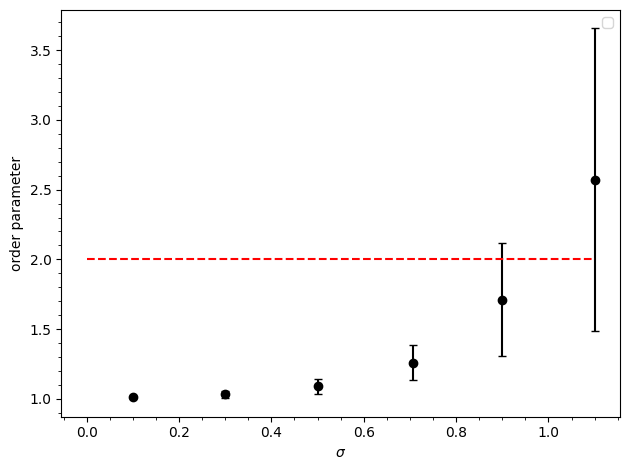

In [463]:
import numpy as np
from scipy.integrate import solve_ivp

RNG = np.random.default_rng()

def A_matrix_calculator(matrix_parameters):
    N, s, sigma, gamma = matrix_parameters

    mu = s / N
    var = sigma**2 / N
    cov = gamma * var
    covmat = np.array([[var, cov], [cov, var]])

    S = np.empty((N, N), dtype=float)
    S.fill(np.nan)
    di = np.diag_indices(N)
    S[di] = 0.0

    iu, ju = np.triu_indices(N, k=1)
    m = iu.size
    if m > 0:
        draws = RNG.multivariate_normal(mean=[mu, mu], cov=covmat, size=m)
        S[iu, ju] = draws[:, 0]
        S[ju, iu] = draws[:, 1]

    return S

# def A_matrix_calculator(matrix_parameters):
#     N, s, sigma, gamma = matrix_parameters
#     mean = 0
#     std = sigma
#     # rng = np.random.default_rng()
#     # Generate upper triangle (excluding diagonal)
#     iu, ju = np.triu_indices(N, k=1)
#     upper_vals = RNG.normal(loc=mean, scale=std, size=len(iu))
#     S = np.zeros((N, N), dtype=float)
#     S[iu, ju] = upper_vals
#     S[ju, iu] = upper_vals  # Symmetrize
#     return S

def dndt(t, n_arr, r, k, migration, A_matrix):
    # ensure no negative populations when calculating derivatives
    n_arr = np.maximum(n_arr, 0.0)

    interaction_terms = A_matrix.dot(n_arr)
    return (r / k) * n_arr * (k - n_arr) - n_arr * interaction_terms + migration

stability_tol = 1e-10

def stable_event(t, n_arr, r, k, migration, A_matrix):
    """
    Event: max |d(ln n)/dt| - stability_tol
    Return crosses zero when system is 'stable' in the paper's sense.
    """
    n_dot = dndt(t, n_arr, r, k, migration, A_matrix)

    # d(ln n)/dt = (1/n) * dn/dt -> use n_arr as denominator, protect zeros
    epsilon = 1e-300
    n_safe = np.maximum(n_arr, epsilon)

    dln_dt = n_dot / n_safe
    max_abs = np.max(np.abs(dln_dt))

    return max_abs - stability_tol

def solver(N, t_span, A_matrix, r, k, n_0):
    migration = 1e-18
    t_array = np.arange(t_span[0], t_span[1], 0.1)

    # fun and event wrapper to bind extra args
    fun = lambda t, y: dndt(t, y, r, k, migration, A_matrix)
    event = lambda t, y: stable_event(t, y, r, k, migration, A_matrix)

    # set event attributes on the wrapper so solve_ivp recognizes them
    event.terminal = True
    event.direction = -1

    sol = solve_ivp(fun, t_span=t_span, y0=n_0, method='BDF', t_eval=t_array,
                    rtol=1e-9, atol=1e-12, events=event, max_step=1.0,
                    vectorized=False)
    return sol

def GLV_solver_new(N, sigma, r, k, n_0, A_matrix=None):
    """
    If A_matrix is provided, use it; otherwise generate one using defaults s=1, gamma=0.5.
    """
    s = 1
    gamma = 0.5
    if A_matrix is None:
        A_matrix = A_matrix_calculator((N, s, sigma, gamma))

    t_span = (0, 10000)
    sol = solver(N, t_span, A_matrix, r, k, n_0)

    max_population = 50

    if np.any(sol.y > max_population):
        print("Max population exceeded!")
        a = np.empty(N); a.fill(np.nan)
        return a

    if sol.t_events and len(sol.t_events[0]) > 0:
        print("Stability event time(s):", sol.t_events[0])
        pass
    else:
        print("No stability event occurred within t_span.")

    final_populations = sol.y.T[-1]

    if not np.all(np.isfinite(final_populations)):
        print("GLV_solver_new: final populations contain non-finite values -> returning nan vector")
        return np.full(N, np.nan)
    
    return final_populations

def order_calculator_new(N, sigma):
    r_i = 1.0
    k_i = 1.0

    # starting condition
    n_0 = np.zeros(N)

    # generate one A_matrix and reuse it for both solves
    s = 1
    gamma = 0.5
    A_matrix = A_matrix_calculator((N, s, sigma, gamma))

    # original solution using that A_matrix
    n_f = GLV_solver_new(N, sigma, r_i, k_i, n_0, A_matrix=A_matrix)

    if not np.all(np.isfinite(n_f)):
        print("order_calculator_new: original simulation failed -> returning nan")
        return np.nan
    # perturbed parameters
    r_f = r_i + 0.1
    k_f = r_f * k_i / r_i

    # perturbed solution using the *same* A_matrix
    perturbed_n_f = GLV_solver_new(N, sigma, r_f, k_f, n_f, A_matrix=A_matrix)

    # comparing only first species
    # species_index = 0
    # order_parameter = (perturbed_n_f[species_index] - n_f[species_index]) / (r_f - r_i) + \
    #                 (perturbed_n_f[species_index] - n_f[species_index]) / (k_f - k_i)

    if not np.all(np.isfinite(perturbed_n_f)):
        print("order_calculator_new: perturbed simulation failed -> returning nan")
        return np.nan
    
    order_parameter = np.nanmean((perturbed_n_f - n_f) / (r_f - r_i) + \
                       (perturbed_n_f - n_f) / (k_f - k_i))
    
    return order_parameter

def step_function_new(N, sigma, total_iterations):

    delta_N_list = []
    for i in range(total_iterations):
        delta_N_list.append(order_calculator_new(N, sigma))

    delta_N_array = np.array(delta_N_list)

    threshold = 5

    filtered_delta_N_array = delta_N_array[abs(delta_N_array) <= threshold]

    return filtered_delta_N_array

# order_calculator_new(10, 0)
std_array = np.array([0.1, 0.3, 0.5, 1 / np.sqrt(2), 0.9, 1.1])
total_iterations = 100; N = 50

mean_order_parameter_arr = []
std_order_parameter_arr = []
for i, std in enumerate(std_array):
    filtered_delta_N_array = step_function_new(N, std, total_iterations)
    mean_order_parameter_arr.append(np.mean(filtered_delta_N_array))
    std_order_parameter_arr.append(np.std(filtered_delta_N_array))
    
import matplotlib.pyplot as plt

plt.errorbar(std_array, mean_order_parameter_arr, yerr = std_order_parameter_arr, fmt = 'ko', capsize = 3)
plt.hlines(2, 0, std_array[-1], color = 'r', linestyles='--')
plt.xlabel(r"$\sigma$")
plt.ylabel(r"order parameter")
plt.legend()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [458]:
import numpy as np
from scipy.integrate import solve_ivp

def A_matrix_calculator(N, s=1.0, sigma=1.0, gamma=0.5, rng=None, correlated=True):
    """
    Generate symmetric interaction matrix A (NxN).
    If correlated=True, draws correlated pairs (i,j) and (j,i) from a bivariate normal
    with mean s/N and covariance gamma*var where var = sigma^2/N (keeps original behavior).
    If correlated=False, draws independent normal entries for upper triangle and mirrors them.
    """
    if rng is None:
        rng = np.random.default_rng()

    mu = s / N
    var = sigma**2 / N
    cov = gamma * var

    # prepare empty matrix with zeros on diagonal
    S = np.zeros((N, N), dtype=float)

    iu, ju = np.triu_indices(N, k=1)
    m = iu.size
    if m == 0:
        return S

    if correlated:
        covmat = np.array([[var, cov], [cov, var]])
        # draws.shape == (m, 2) where draws[:,0] -> entry (i,j) and draws[:,1] -> entry (j,i)
        draws = rng.multivariate_normal(mean=[mu, mu], cov=covmat, size=m)
        S[iu, ju] = draws[:, 0]
        S[ju, iu] = draws[:, 1]
    else:
        # simpler uncorrelated symmetric entries (faster)
        upper = rng.normal(loc=mu, scale=np.sqrt(var), size=m)
        S[iu, ju] = upper
        S[ju, iu] = upper

    return S


def dndt(t, n, r, k, migration, A):
    """
    Right-hand side of GLV / logistic-interaction model:
    dn/dt = (r/k) * n * (k - n) - n * (A @ n) + migration

    n is assumed to be 1D array (shape (N,))
    """
    # protect against negative populations in the derivative calculation, but do not modify `n` in-place
    n_pos = np.where(n > 0.0, n, 0.0)

    interaction_terms = A.dot(n_pos)          # shape (N,)
    growth = (r / k) * n_pos * (k - n_pos)    # shape (N,)

    return growth - n_pos * interaction_terms + migration


def jacobian(t, n, r, k, migration, A, A_diag=None):
    """
    Jacobian matrix J_ij = d(dn_i/dt) / d n_j
    Derived from d/dn of: (r/k) n_i (k - n_i) - n_i * (A n)_i + migration
    For i == j:
        J_ii = (r/k) (k - 2 n_i) - (A n)_i - n_i * A_ii
    For i != j:
        J_ij = - n_i * A_ij
    """
    if A_diag is None:
        A_diag = np.diag(A)

    n_pos = np.where(n > 0.0, n, 0.0)
    An = A.dot(n_pos)

    # diagonal part
    diag_vals = (r / k) * (k - 2.0 * n_pos) - An - n_pos * A_diag

    # Build Jacobian efficiently:
    # J = - np.outer(n_pos, np.ones(N)) * A  but need diag replaced by diag_vals
    # Off-diagonals: - n_i * A_ij  (i != j)
    # Create full matrix -n_i * A_ij
    J = - (n_pos[:, None] * A)           # shape (N,N)
    # replace diagonal with diag_vals
    np.fill_diagonal(J, diag_vals)

    return J


# Stability tolerance for event
STABILITY_TOL = 1e-10


def stable_event_factory(r, k, migration, A):
    """
    Return an event function with attributes `terminal` and `direction`.
    The event function returns (max_abs(d ln n / dt) - STABILITY_TOL).
    """

    def event(t, n):
        # compute dn/dt once and reuse
        n_dot = dndt(t, n, r, k, migration, A)
        # protect denom
        eps = 1e-300
        n_safe = np.where(n > 0.0, n, eps)
        dln_dt = n_dot / n_safe
        max_abs = np.max(np.abs(dln_dt))
        return max_abs - STABILITY_TOL

    event.terminal = True
    # direction = -1: event occurs when quantity decreases through zero (paper used < tol)
    event.direction = -1
    return event


def solver(N, t_span, A, r, k, n0, migration=1e-18, jac_provide=True, t_eval=None,
           rtol=1e-9, atol=1e-12, max_step=1.0):
    """
    Solve the ODE system. Returns the `solve_ivp` result.
    If jac_provide is True, a Jacobian function is provided to speed up BDF.
    """

    fun = lambda t, y: dndt(t, y, r, k, migration, A)

    event = stable_event_factory(r, k, migration, A)

    # optionally provide jacobian for BDF
    jac = None
    if jac_provide:
        A_diag = np.diag(A)
        jac = lambda t, y: jacobian(t, y, r, k, migration, A, A_diag=A_diag)

    # let t_eval be default (None) unless user provides it; calling code previously used dense t_eval=0.1
    sol = solve_ivp(fun, t_span=t_span, y0=n0, method='BDF', t_eval=t_eval,
                    rtol=rtol, atol=atol, events=event, max_step=max_step, jac=jac)
    return sol


def GLV_solver_new(N, sigma, r, k, n0, A_matrix=None, s=1.0, gamma=0.5,
                   rng=None, t_span=(0, 10000), migration=1e-18, **solver_kwargs):
    """
    Top-level GLV solver wrapper.
    If A_matrix is None, build one using provided (N, s, sigma, gamma).
    Returns final populations (vector), and the solve_ivp object if needed.
    """

    if rng is None:
        rng = np.random.default_rng()

    if A_matrix is None:
        A_matrix = A_matrix_calculator(N, s=s, sigma=sigma, gamma=gamma, rng=rng)

    # do not request dense t_eval by default; set to None and use solver-chosen timesteps.
    sol = solver(N, t_span, A_matrix, r, k, n0, migration=migration, **solver_kwargs)

    # informational checks
    max_population = 50
    if np.any(sol.y > max_population):
        
        print("Warning: max population exceeded!")

    if sol.t_events and len(sol.t_events[0]) > 0:
        print("Stability event time(s):", sol.t_events[0])
    else:
        print("No stability event occurred within t_span.")

    final_populations = sol.y[:, -1]
    return final_populations, sol


def order_calculator_new(N, sigma, rng=None):
    """
    Compute order parameter using same A_matrix for both baseline and perturbed solves.
    Preserves previous numerical choices but returns the computed order parameter.
    """
    if rng is None:
        rng = np.random.default_rng()

    r_i = 1.0
    k_i = 1.0
    n0 = np.zeros(N)

    # generate one A_matrix and reuse it for both solves
    s = 1.0
    gamma = 0.5
    A_matrix = A_matrix_calculator(N, s=s, sigma=sigma, gamma=gamma, rng=rng)

    n_f, sol1 = GLV_solver_new(N, sigma, r_i, k_i, n0, A_matrix=A_matrix, rng=rng)

    # perturbed parameters
    r_f = r_i + 0.1
    k_f = r_f * k_i / r_i

    perturbed_n_f, sol2 = GLV_solver_new(N, sigma, r_f, k_f, n_f, A_matrix=A_matrix, rng=rng)

    species_index = 0
    # avoid division by zero if r_f == r_i or k_f == k_i (they aren't here, but safe practice)
    dr = (r_f - r_i) if r_f != r_i else np.finfo(float).eps
    dk = (k_f - k_i) if k_f != k_i else np.finfo(float).eps

    order_parameter = ((perturbed_n_f[species_index] - n_f[species_index]) / dr +
                       (perturbed_n_f[species_index] - n_f[species_index]) / dk)

    return order_parameter


def step_function_new(N, sigma, total_iterations, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    arr = [order_calculator_new(N, sigma, rng=rng) for _ in range(total_iterations)]
    delta_N_array = np.array(arr)
    threshold = 5
    return delta_N_array[np.abs(delta_N_array) <= threshold]


# Example usage (unchanged semantics from your script)
if __name__ == "__main__":
    std_array = np.array([0.1, 0.3, 0.5, 1 / np.sqrt(2), 0.9, 1.1])
    total_iterations = 30
    N = 30

    rng = np.random.default_rng(12345)   # deterministic runs for reproducibility

    mean_order_parameter_arr = []
    std_order_parameter_arr = []

    for std in std_array:
        filtered = step_function_new(N, std, total_iterations, rng=rng)
        mean_order_parameter_arr.append(np.mean(filtered))
        std_order_parameter_arr.append(np.std(filtered))

    import matplotlib.pyplot as plt
    plt.errorbar(std_array, mean_order_parameter_arr, yerr=std_order_parameter_arr, fmt='ko', capsize=3)
    plt.hlines(2, 0, std_array[-1], color='r', linestyles='--')
    plt.xlabel(r"$\sigma$")
    plt.ylabel(r"order parameter")
    plt.legend()
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()


Stability event time(s): [86.43796732]
Stability event time(s): [19.14463537]
Stability event time(s): [87.27455982]
Stability event time(s): [19.14466559]
Stability event time(s): [86.30541965]
Stability event time(s): [19.14492415]
Stability event time(s): [89.38682723]
Stability event time(s): [19.1447373]
Stability event time(s): [86.32879633]
Stability event time(s): [19.14484797]
Stability event time(s): [83.68794267]
Stability event time(s): [19.14471078]


KeyboardInterrupt: 